## Imports and Installs

In [1]:
# Install tensorflow 2.0 if you don't already have it
# !pip install tensorflow-gpu==2.0.0-beta0

import tensorflow as tf
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np

import IPython.display as display
# Sets the default figsize
mpl.rcParams['figure.figsize'] = (12,12)
# Turns off gridlines by default
mpl.rcParams['axes.grid'] = False

print(f"TF Version: {tf.__version__}")

TF Version: 2.0.0-beta0


Verify that a GPU is available

In [2]:
# If using Google Colab, make sure the runtime type is 'GPU'
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


## Data Preprocessing

In [0]:
# Downloads the file from the link, returns the path of the downloaded file
content_path = tf.keras.utils.get_file('turtle.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Green_Sea_Turtle_grazing_seagrass.jpg')
style_path = tf.keras.utils.get_file('kandinsky.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

In [0]:
def load_img(img_path):
    """Loads image from file and performs some preprocessing
    Args:
        img_path (str): the path for the image file
    Returns:
        img ((1, h, w, c) tf.EagerTensor): the image as a 1 x h x w x c EagerTensor
    """
    max_dim = 512
    img = tf.io.read_file(img_path)
    # Converts compressed image to integers [0-255]
    img = tf.image.decode_image(img, channels=3)
    # Converts image from [0-255] to [0-1]
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Gets H and W dimensions
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    # Gets a shape proportional to the old shape such that new_long_dim == max_dim
    new_shape = tf.cast(shape*scale, tf.int32)
    # Resizes images according to: https://github.com/tensorflow/tensorflow/blob/r1.13/tensorflow/python/ops/image_ops_impl.py#L964
    # Upsamples or downsamples as appropriate
    img = tf.image.resize(img, new_shape)
    # Unsqueezes a zeroth dimension
    img = img[tf.newaxis, :]
    return img

def imshow(image, title=None):
    """Displays an image
    Args:
        image ((1 x h x w x c) or (h x w x c) tf.EagerTensor): the image to display
    """
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)

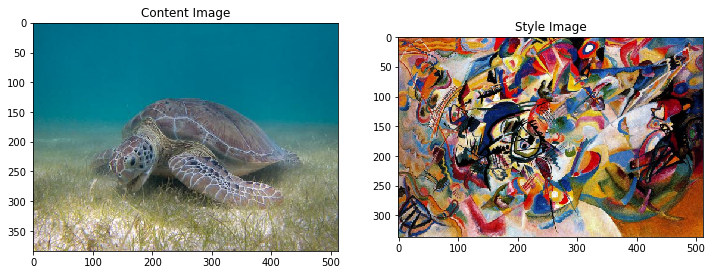

In [5]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(2, 2, 1)
imshow(content_image, 'Content Image')
plt.subplot(2, 2, 2)
imshow(style_image, 'Style Image')

## Get Content and Style Representations
The content representation comes from the last layer of a pretrained CNN, because the later layers learn higher-level features. The style representation is taken from several layers of a pretrained CNN.

### Show that this Pretrained VGG Network gets good representations

In [6]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
# Stretches image to 224x224 (no crop)
x = tf.image.resize(x, (224, 224))
# Load a pretrained VGG19 model (including the last 3 fcl's of the network)
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
# Get a prediction for x
r = vgg(x)
# Show the VGG network predicts accurately for this type of image (meaning it 
# obtains a good representation)
labels_path = tf.keras.utils.get_file(
    'ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())
print(imagenet_labels[np.argsort(r)[0,::-1][:5]+1])

['loggerhead' 'leatherback turtle' 'hermit crab' 'terrapin' 'mud turtle']


### Examine Layers

In [7]:
# Get a pretrained vgg network again, this time without the last 3 fcl's
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
# Examine the layers
for layer in vgg.layers:
    print(layer.name)
# The layers of the vgg representation of the content image that we want to match
content_layers = ['block5_conv2']
# The layers of the vgg representation of the style image that we want to match
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


## Optimize Input Image to Match Style and Content Representations

In [0]:
def vgg_layers(layer_names):
    """Creates a vgg model that returns a list of intermediate activations
    rather than the final output value.
    Args:
        layer_names (list of str): the layers to report the activations of
    Returns:
        model (tf.keras.Model): a Model that takes as input an image and returns
            as output the activations of the specified layers of a pretrained 
            VGG network
    """
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    # Make the network un-trainable, since we are using it just to obtain a representation
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

Let's take a look a what these activations look like

In [9]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)
#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()
# Check for understanding:
# What does vgg.get_layer() do?
# What is tf.keras.Model()?
# What is vgg.input?
# What does ....vgg19.preprocess_input() do?

block1_conv1
  shape:  (1, 336, 512, 64)
  min:  0.0
  max:  835.5256
  mean:  33.97525

block2_conv1
  shape:  (1, 168, 256, 128)
  min:  0.0
  max:  4625.8857
  mean:  199.82687

block3_conv1
  shape:  (1, 84, 128, 256)
  min:  0.0
  max:  8789.239
  mean:  230.78099

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  21566.135
  mean:  791.24005

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3189.2542
  mean:  59.179478



Here we will define a wrapper class for the vgg model. This wrapper class will take in an image and return the VGG activations

In [0]:
def gram_matrix(input_tensor):
    """Constructs a gram matrix for each style layer's activations. We compare
    this matrix when matching style (rather than comparing the raw activations)
    Args:
        input_tensor ((1 x h x w x c) tf.EagerTensor): one style layer
    Returns:
        gram ((1 x h x w x c) tf.EagerTensor): the gram matrix for this layer, 
            of the same shape as input_tensor
    """
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor) # result[b, c, d] = sum_i sum_j input_tensor[b, i, j, c] * input_tensor[b, i, j, d]
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32) # = h * w (of the activations, not the original image)
    # Scale the gram matrix by the number of entries in the activations of this layer
    gram = result/(num_locations)
    return gram

class StyleContentModel(tf.keras.Model):
    """A wrapper for a VGG19 neural network. Returns a dictionary of activations
    rather than the final VGG19 output"""
    def __init__(self, style_layers, content_layers):
        """Initializes the StyleContentModel class by defining a VGG model that
        reports the activations of specified layers.
        Args:
            style_layers (list of str): a list of the str with the names of the 
                desired style layers to match
            content_layers (list of str): a list of the str with the names of the 
                desired content layers to match 
        """
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        # We just use the VGG network to get representations; the vgg network
        # is never trained
        self.vgg.trainable = False
        self.style_layer_len = len(style_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        
    def __call__(self, x):
        """The feed-forward method of the StyleContentModel
        Args:
            x ((1 x h x w x c) tf.EagerTensor): with values in [0, 1] - the image to optimize.
        Returns:
            (dict of dict of tf.EagerTensor): a dictionary containing two
                dictionaries: one holding representations of the style
                activations and the other dictionary holding the content activations
        """
        # Preprocess input image
        x = x * 255
        x_preprocessed = tf.keras.applications.vgg19.preprocess_input(x)
        
        # Get activations of vgg network for image
        activations = self.vgg(x_preprocessed)
        style_activations = activations[:self.style_layer_len]
        content_activations = activations[self.style_layer_len:]
        style_grams = [gram_matrix(style_activation) 
                      for style_activation in style_activations]
        
        style_layer_dict = {style_name:value
                         for style_name, value
                         in zip(self.style_layers, style_grams)}
        content_layer_dict = {content_name:value
                           for content_name, value
                           in zip(self.content_layers, content_activations)}
        
        return {'style':style_layer_dict, 'content':content_layer_dict}

Here we define some helper functions for training, including the loss function. The loss function incentivizes the activations of the input image to match certain activations of the style and content images.

In [0]:
def clip_0_1(image):
    """Clips image values to fall in the proper range ([0, 1]).
    Args:
        image ((1 x h x w x c) tf.ResourceVariable): the image with raw values
    Returns:
        ((1 x h x w x c) tf.Tensor): the image with values clipped to be in [0, 1]
    """
    return tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)

def style_content_loss(outputs):
    """A loss function that penalizes the style and content outputs for being
    different from the style and content targets.
    Args:
        outputs (dict of dict of tf.EagerTensor): the activations from the 
            StyleContentModel
    Returns:
        loss (() tf.Tensor): the style and content loss
    """
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    # Gather MSE loss across each layer
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2) 
                           for name in style_outputs.keys()])
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2) 
                             for name in content_outputs.keys()])
    # Scale appropriately
    style_loss *= style_weight / num_style_layers
    content_loss *= content_weight / num_content_layers
    
    loss = style_loss + content_loss
    return loss

@tf.function()
def train_step(image):
    """Conducts one step of training with 'image' and updates the values of 'image'
    Args:
        image ((1 x h x w x c) tf.EagerTensor): the image to optimize    
    """
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
    
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))    

A quick test to see if our style transfer model is working as we expect it to:

W0614 17:01:33.833120 139899232290688 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


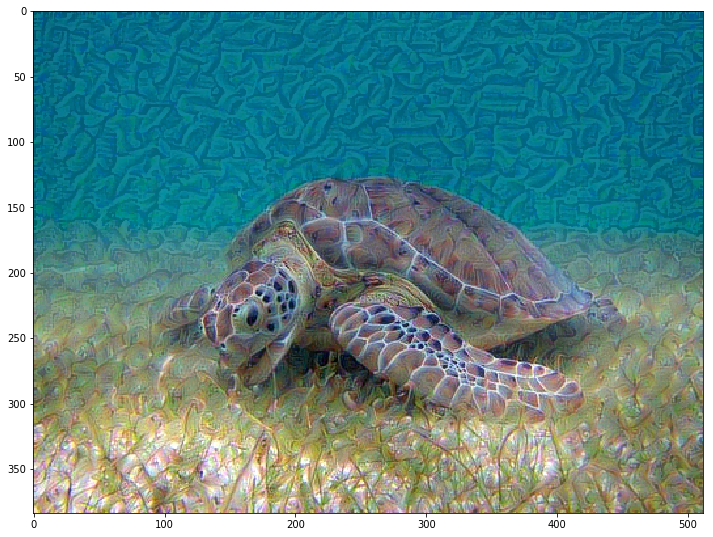

In [12]:
extractor = StyleContentModel(style_layers, content_layers)
content_targets = extractor(content_image)['content']
style_targets = extractor(style_image)['style']

# Make the image a tf.Variable so that we can optimize over it
image = tf.Variable(content_image)
opt = tf.optimizers.Adam(learning_rate=.02, beta_1=.99, epsilon=1e-1)
style_weight = 1e-2
content_weight = 1e4

train_step(image)
train_step(image)
train_step(image)
plt.imshow(image.read_value()[0])

It works! Now a longer optimization:

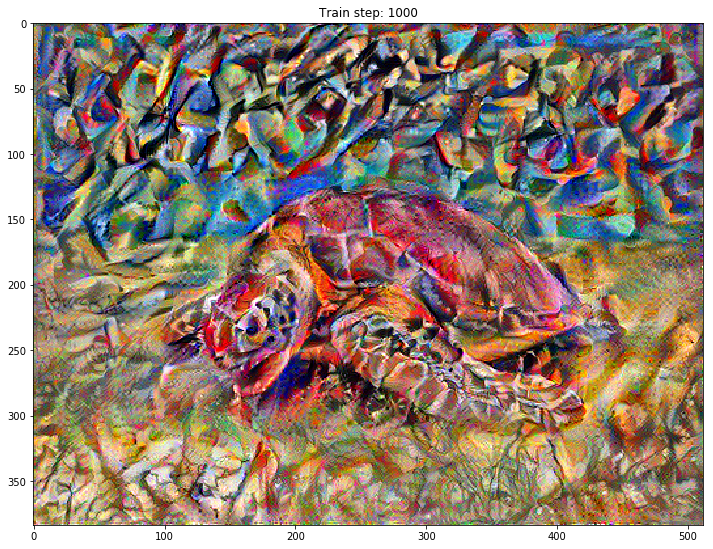

Total time: 174.7


In [13]:
import time
start = time.time()
# These are not traditional epochs, as we don't have a dataset to iterate through
epochs = 10
steps_per_epoch = 100
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    imshow(image.read_value())
    plt.title("Train step: {}".format(step))
    plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))

Notice the high-frequency artifacts in this optimized image. We can remedy these by using a
regularization term on the high-frequency components of the image. This regularization is called the *total variation loss*

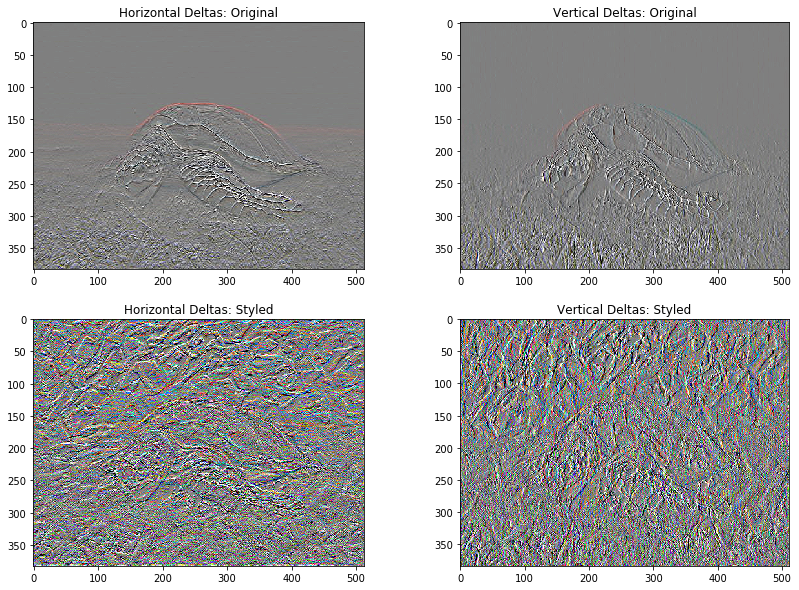

In [14]:
def high_pass_x_y(image):
    """This is an edge detector, detecting horizontal and vertical edges in an
    image.
    Args:
        image ((1 x h x w x c) tf.ResourceVariable): the image we are optimizing
    Returns:
        x_var ((1 x h x (w - 1) x c) tf.EagerTensor): a matrix of deltas
            with larger values where there are horizontal edges
        y_var ((1 x (h - 1) x w x c) tf.EagerTensor): a matrix of deltas
            with larger values where there are vertical edges
    """
    x_var = image[:,:,1:,:] - image[:,:,:-1,:]
    y_var = image[:,1:,:,:] - image[:,:-1,:,:]
    return x_var, y_var

x_deltas, y_deltas = high_pass_x_y(content_image)
plt.figure(figsize=(14,10))

plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+.5), "Horizontal Deltas: Original")
plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+.5), "Horizontal Deltas: Styled")
plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+.5), "Vertical Deltas: Styled")

This shows the presence of high-frequency components in the styled image that didn't exist in the original image. Since we use the high-pass filter as an edge detectore, we can use other edge detectors as a substitute, e.g. the Sobel edge detector:

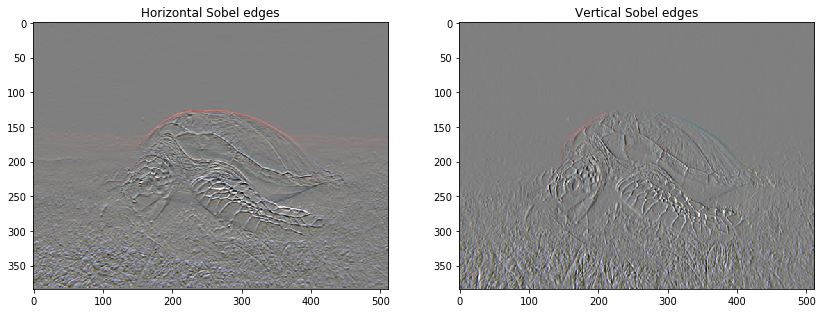

In [15]:
plt.figure(figsize=(14,10))
sobel = tf.image.sobel_edges(content_image)
plt.subplot(1,2,1)
imshow(clip_0_1(sobel[...,0]/4+.5), "Horizontal Sobel edges")
plt.subplot(1,2,2)
imshow(clip_0_1(sobel[...,1]/4+.5), "Vertical Sobel edges")

Suppose we want to rid ourselves of such undesireable features. The solution? Penalize high edge values in the loss function!

In [0]:
def total_variation_loss(image):
    """Obtains the regularization loss that penalizes the stylized image for 
    having high-frequency components
    Args:
        image ((1 x h x w x c) tf.EagerTensor): the stylized image
    Returns:
        (() tf.Tensor): the regularization penalty for the loss function
    """
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_mean(x_deltas**2) + tf.reduce_mean(y_deltas**2)    

Now we optimize again, but this time with a regularization penalty in the loss function

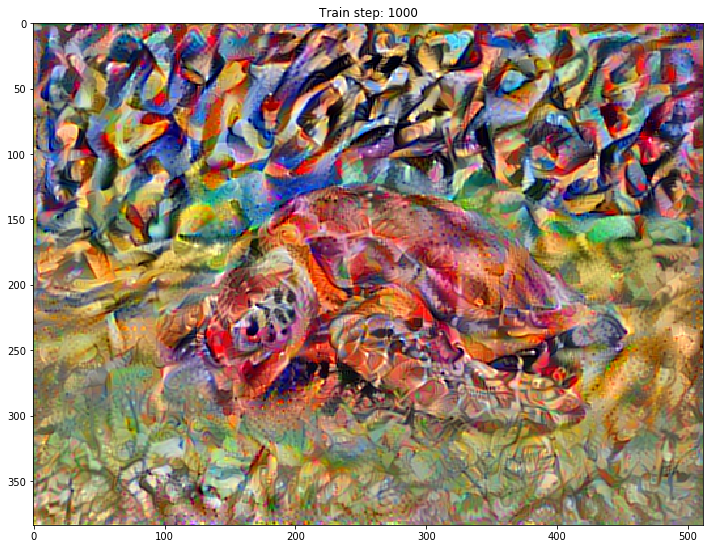

Total time: 178.4950087070465


In [17]:
total_variation_weight = 1e8
# Redefine the train_step function with this added loss term
@tf.function()
def train_step(image):
    """Conducts one step of training with 'image' and updates the values of 'image'
    Args:
        image ((1 x h x w x c) tf.EagerTensor): the image to optimize    
    """
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight*total_variation_loss(image)
        
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))
    
# Re-initialize the image to optimize
image = tf.Variable(content_image)
# Run the optimization
import time
start = time.time()
epochs = 10
steps_per_epoch = 100
step = 0
for _ in range(epochs):
    for _ in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    imshow(image.read_value())
    plt.title("Train step: {}".format(step))
    plt.show()
    
end = time.time()
print(f"Total time: {end - start}")

In [0]:
# Finally, save the result
file_name = 'kandinsky-turtle.png'
mpl.image.imsave(file_name, image[0])

try: 
    from google.colab import files
except ImportError:
    pass
else:
    files.download(file_name)